# GAM Pyro Examples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from orbit.models.gam import GAMFull
from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [4]:
DATA_FILE = "./data/iclaims_example.csv"
date_col = 'week'
response_col = 'claims'
df = pd.read_csv(DATA_FILE, parse_dates=[date_col])
df.dtypes

week              datetime64[ns]
claims                     int64
trend.unemploy           float64
trend.filling            float64
trend.job                float64
dtype: object

In [5]:
df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] =\
    df[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log)

In [6]:
df_fs, fs_cols = make_fourier_series_df(df, 'week', 52, order=2)

In [7]:
df_fs.head()

,week,claims,trend.unemploy,trend.filling,trend.job,fs_cos1,fs_sin1,fs_cos2,fs_sin2
0,2010-01-03,13.38660,0.16888,-0.32831,0.11303,0.12054,-0.99271,-0.23932,0.97094
1,2010-01-10,13.62422,0.16888,-0.20470,0.16433,-0.66312,-0.74851,0.99271,0.12054
2,2010-01-17,13.39874,0.18514,-0.30233,0.11303,-1.00000,-0.00000,0.00000,-1.00000
3,2010-01-24,13.13755,0.15235,-0.20470,0.10245,-0.66312,0.74851,-0.99271,0.12054
4,2010-01-31,13.19676,0.08335,-0.25232,0.07002,0.12054,0.99271,0.23932,0.97094


### Train / Test Split

In [8]:
test_size=52
train_df=df_fs[:-test_size]
test_df=df_fs[-test_size:]

## VI Fit and Predict

Pyro only support Variational Inference(SVI) for full sampling prediction.  Note that `pyro` takes advantage of parallel processing in `vi` and hence result in similar computation time compared to `map`.

In [9]:
gam_vi = GAMFull(
    response_col='claims',
    date_col='week',
    regressor_col=fs_cols + ['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_sign=['='] * 4 + ['+'] *3,
    
    level_latent_sigma = 10,
    regressor_latent_loc_prior=[0] * 7,
    regressor_latent_scale_prior=[1] * 4 + [0.1] * 3,
    positive_regressor_step_scale_prior=.1,
    span_level=0.1,
    span_regressor=0.2,
    rho_level=0.05,
    rho_regressor=0.1,
    insert_prior_idx=None,
    insert_prior_tp_idx=None,
    insert_prior_mean=None,
    insert_prior_sd=None,
    
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    verbose=True,
    message=100,
    n_bootstrap_draws=-1,
    estimator_type=PyroEstimatorVI,
)

In [10]:
%%time
gam_vi.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 1.7649e+05, scale = 0.11933
step  100 loss = 15895, scale = 0.71599
step  200 loss = -37.494, scale = 0.29633
step  300 loss = -67.268, scale = 0.30275
step  400 loss = -64.338, scale = 0.29579
step  500 loss = -66.676, scale = 0.2985
step  600 loss = -69.127, scale = 0.30149
step  700 loss = -66.99, scale = 0.29303
step  800 loss = -68.254, scale = 0.29188
step  900 loss = -69.313, scale = 0.28809
CPU times: user 2min 53s, sys: 4.32 s, total: 2min 57s
Wall time: 16.6 s


In [11]:
# data_input = gam_vi._get_model_data_input()
# data_input

In [12]:
# gam_vi._get_model_param_names()

In [13]:
predicted_df = gam_vi.predict(df=test_df)

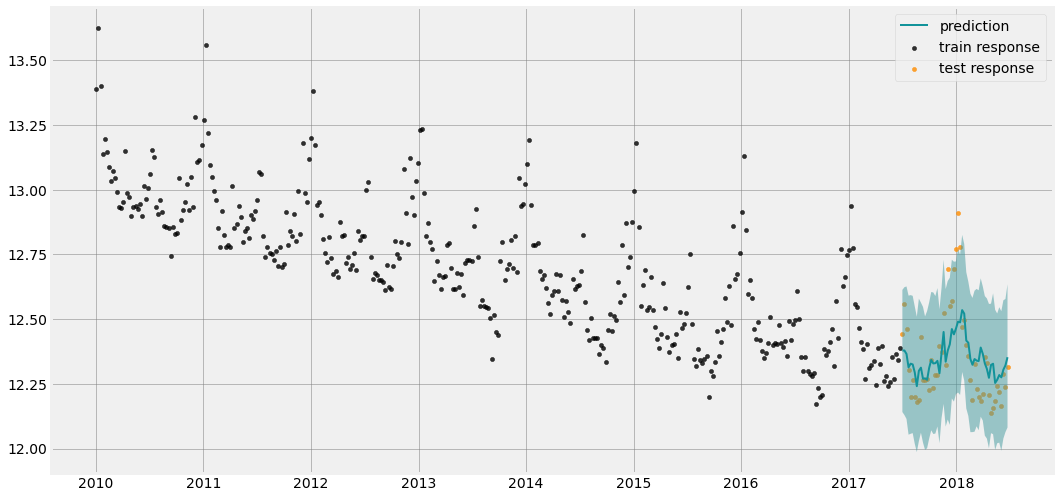

In [14]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=gam_vi.date_col, actual_col=gam_vi.response_col, 
                    test_actual_df=test_df)

In [15]:
coef_df = gam_vi.get_regression_coefs()
coef_df.head()

,week,fs_cos1,fs_sin1,fs_cos2,fs_sin2,trend.unemploy,trend.filling,trend.job
0,2010-01-03,-0.04870,-0.02705,0.03898,0.02791,0.30790,0.50894,0.04230
1,2010-01-10,-0.04850,-0.02667,0.03885,0.02757,0.30949,0.50841,0.04232
2,2010-01-17,-0.04848,-0.02622,0.03852,0.02722,0.31099,0.50764,0.04250
3,2010-01-24,-0.04817,-0.02579,0.03814,0.02695,0.31194,0.50721,0.04264
4,2010-01-31,-0.04795,-0.02534,0.03779,0.02674,0.31289,0.50632,0.04264


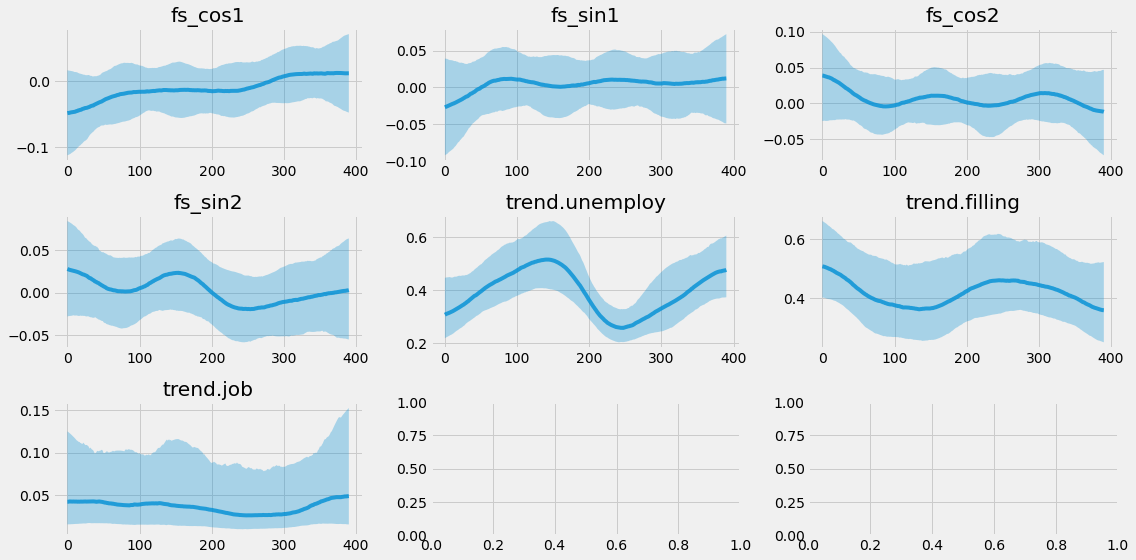

In [16]:
_ = gam_vi.plot_regression_coefs(ncol=3, figsize=(16, 8), include_ci=True)